# Introdução a Séries Temporais

Tutorial for improve skills: 'Séries Temporais com python/pandas/statsmodels - Parte 01' (ORMaster) by Marcus Mariano

**For more information about Marcus Mariano: [Web site](https://marcusmariano.github.io/mmariano/)**  

**Séries Temporais com python/pandas/statsmodels - Parte 01 [ORMaster.](https://www.youtube.com/playlist?list=PL5fQ3JoS0SZscDaHgXahtx632NMnq5RR-)** 

**ronaldolagepessoa: [GitHub.](https://github.com/ronaldolagepessoa/timeseries)**

In [1]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", color_codes=True)
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Set parameters

In [3]:
N_THREADS = 6 # threads cnt for lgbm and linear models
N_FOLDS = 10 # folds cnt for AutoML
N_JOBS = -1 # -1 means using all processors
SEED = 0 # fixed random state for various reasons
TEST_SIZE = 0.3 # Test size for metric check
VERBOSE = 1
EPOCHS = 50
TIMEOUT = 600 # Time in seconds for automl run, 600 seconds = 10 minutes
RAM = 16 #  Number of RAM limit
CPU_LIMIT = 16 # Number of CPU limit
TARGET_NAME = 'CHURN'

## Autocorrelação Total e Parcial

A autocorrelação é a medida de correlação entre uma variável e valores passados da mesma. Na autocorrelação total, a correlação entre a observação $X_t$ e a observação $X_{t - p}$ é calculada levando em consideração a dependência linear das observações intermediárias $X_{t - 1}, X_{t - 2}, \ldots, X_{t - p + 1}$. A autocorrelação parcial, por outro lado, calcula a correlação entre a observação $X_{t}$ e $X_{t - p}$ eliminando a dependência linear das observações intermediárias.

Utilizaremos as informações de vendas contidas no arquivo ```shampoo.csv``` para exemplificar a criação dos dois gráficos.

In [4]:
Path = ""

data = pd.read_csv(Path+"data/shampoo.csv")
print(data.shape)
data.head()

(36, 2)


,Month,Sales
0,2000-01,266.0
1,2000-02,145.9
2,2000-03,183.1
3,2000-04,119.3
4,2000-05,180.3


In [5]:
train = data.copy()

In [6]:
train.Month = pd.to_datetime(train.Month)
train.set_index('Month', inplace=True)
train.head()

,Sales
Month,
2000-01-01,266.0
2000-02-01,145.9
2000-03-01,183.1
2000-04-01,119.3
2000-05-01,180.3


Para criar os gráficos de autocorrelação parcial e total, utilizaremos as funções ```plot_pacf()``` e ```plot_acf()```, respectivamente. As duas funções fazem parte do subpacote ```statsmodels.graphics.tsaplots``` e recebem como parâmetro a ```Series``` contendo a série temporal e o parâmetro ```lags``` para definição do número de períodos anteriores considerados.

Para a correção de _bugs_ na criação do gráfico, acrescentaremos o comando ```plt.show()```.

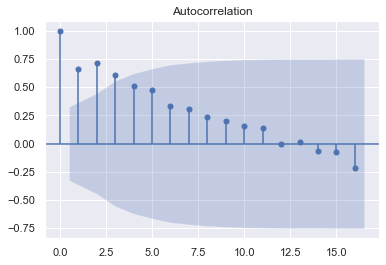

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the total autocorrelation function
plot_acf(train.Sales);

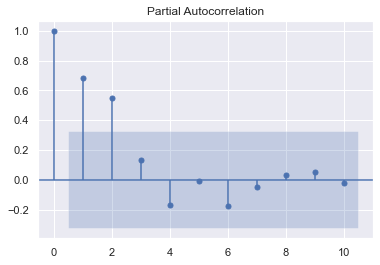

In [10]:
# Plot the partial autocorrelation function
plot_pacf(train.Sales, lags=10);

Utilizamos a autocorrelação parcial como indicador para escolher o valor $p$ para o modelo autoregressivo AR($p$). Para analisar a autocorrelação parcial utilizamos o gráfico de autocorrelação parcial. Definiremos o parâmetro ```lags=10```, para exibir somente os 10 primeiros _lags_.

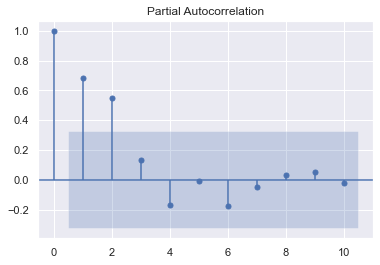

In [12]:
# Plot the partial autocorrelation function
plot_pacf(train.Sales, lags=10);


O resultado obtido é um gráfico tendo como eixos $x$ e $y$ o número de _lags_ e a autocorrelação parcial, respectivamente. 

Estamos interessados no último valor de autocorrelação que não faça parte da região de baixa significância representada pela área em azul claro. O valor de autocorrelação para $p=0$ será sempre 1, uma vez que a correlação de uma variável com ela mesma sempre o será. Para $p > 0$, percebemos que $p=2$ possui é o último valor de autocorrelação parcial dentre os _lags_ com significância estatística.

## Validação _train/test_

Dependendo do modelo preditivo aplicado a uma série temporal, corremos o risco de nos deparar com problemas de _overfitting_. Dessa forma, precisamos estabelecer um procedimento de teste com a dinâmica _train/test_.

Imaginemos o modelo preditivo como sendo um aluno que precisa estudar para uma prova. Para tanto, este tenta resolver um conjunto de questões de uma lista de exercícios. Caso a prova contenha as mesmas questões (ou um sub conjunto) da lista de exercícios, corremos o risco do aluno ter decorado as respostas, obtendo uma nota alta sem ter aprendido de fato sobre o conteúdo. Por outro lado, quando novas questões são aplicadas na prova, o aluno precisa ter aprendido sobre o conteúdo para obter uma nota satisfatória.

A mesma lógica pode ser aplicada para a validação de modelos de séries temporais. Considerando uma séries com $n$ períodos, i.e., $t=1, 2, \ldots, n$, dividiremos o conjunto de períodos em 2. Sendo um reservado para o "treinamento" do modelo e o outro para "testar" o mesmo.

Para séries temporais, o conjunto contendo os períodos mais antigos serão sempre utilizados como conjunto de treinamento. A tamanho do conjunto de treinamento deve, também, sempre ser maior que o conjunto de teste. Essa divisão costuma obedecer a regra: treinamento (2/3) e teste (1/3).

Aplicando o comando python ```len()``` na ```Series```, obtemos o número de períodos para a mesma. Dessa forma, multiplicaremos o número total de períodos por 2/3 e aplicaremos o resultado no comando python ```int()```, para que o resultado seja sempre um número inteiro. Chamaremos o resultado final de ```train_size```.

In [14]:
X_train_size = int(len(train.Sales) * 2 / 3)
X_train_size

24

O conjunto de treinamento conterá os ```train_size = 24``` primeiros períodos da séries temporal. Utilizaremos o comando ```Series[:n]``` para filtrar os $n$ primeiros valores, dando o nome ```train_set``` ao resultado. Para o conjunto de testes denominado ```test_set```, utilizaremos o comando ```Series[n:]```.

In [17]:
X_train = train.Sales[:X_train_size]
X_test = train.Sales[X_train_size:]

X_train.shape, X_test.shape

((24,), (12,))

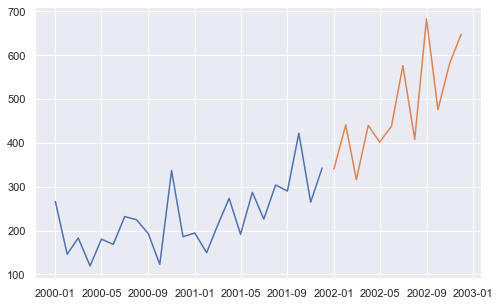

In [20]:
fig = plt.subplots(figsize=(8, 5))

plt.plot(X_train)
plt.plot(X_test);

Criaremos, agora, um modelo auto-regressivo de ordem 2 (AR(2)) a partir do conjunto de treinamento ```train_set```. Acessando o atributo ```params``` obtemos os parâmetros do modelo AR(2).

In [22]:
from statsmodels.tsa.ar_model import AR

ar_2 = AR(X_train, freq='MS').fit(2)
ar_2.params

const       82.005541
L1.Sales     0.183201
L2.Sales     0.488723
dtype: float64

Com base nos parâmetros do modelo AR(2), podemos aplicar o mesmo utilizando a equação
$$X_t = 82.00 + 0.18 X_{t-1} + 0.48 X_{t - 2}$$

Para obter as previsões para o conjunto de testes ```test_set```, aplicaremos a equação acima neste conjunto. Atribuiremos os resultados em uma variável chamada ```previsoes```.

In [24]:
preds = ar_2.params[0] + X_test.shift(1) * ar_2.params[1] + X_test.shift(2) * ar_2.params[2]
preds

Month
2002-01-01           NaN
2002-02-01           NaN
2002-03-01    328.706734
2002-04-01    355.112579
2002-05-01    316.873600
2002-06-01    370.220388
2002-07-01    358.262478
2002-08-01    401.205507
2002-09-01    437.938657
2002-10-01    406.152511
2002-11-01    502.390416
2002-12-01    420.790685
Name: Sales, dtype: float64

Plotaremos, agora, o conjunto de treinamento, teste e as previsões.

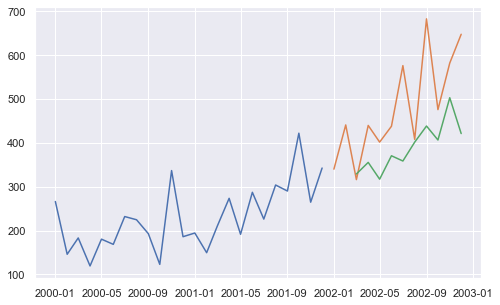

In [25]:
fig = plt.subplots(figsize=(8, 5))


plt.plot(X_train)
plt.plot(X_test)
plt.plot(preds);

Com o gráfico, percebemos que o modelo AR(2) não obteve um resultado satisfatório. Para $p=2$, o modelo não conseguiu responder a mudança de inclinação nas vendas contidas no conjunto de treinamento. O resultado ruim se confirma com o cálculo do erro médio quadrático.

In [26]:
((X_test - preds) ** 2).mean()

18782.49412004275

Faremos, agora, um teste com o modelo AR(5).

In [27]:
ar_5 = AR(train, freq='MS').fit(5)
ar_5.params

const      -20.327360
L1.Sales    -0.289116
L2.Sales     0.370015
L3.Sales     0.311572
L4.Sales     0.415815
L5.Sales     0.465187
dtype: float64

Nesse caso, a equação que defini as previões é do tipo
$$X_t = 0.98 -0.06X_{t-1} + 0.28X_{t-2} + 0.09X_{t-3}+0.54X_{t-4}+0.28X_{t-5}$$

Para automatizar a aplicação do modelo, utilizaremos o loop abaixo.

In [28]:
preds = ar_5.params[0]
for i, param in enumerate(ar_5.params[1:]):
    preds += X_test.shift(i + 1) * param
preds

Month
2002-01-01           NaN
2002-02-01           NaN
2002-03-01           NaN
2002-04-01           NaN
2002-05-01           NaN
2002-06-01    465.772721
2002-07-01    474.798491
2002-08-01    429.785185
2002-09-01    582.277668
2002-10-01    481.180740
2002-11-01    664.377369
2002-12-01    637.171454
Name: Sales, dtype: float64

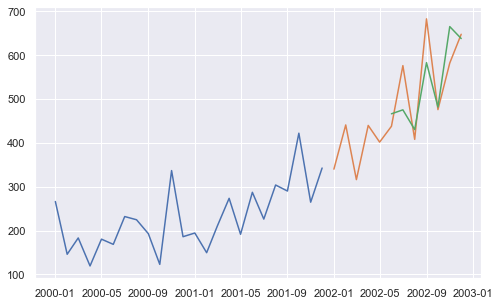

In [30]:
fig = plt.subplots(figsize=(8, 5))

plt.plot(X_train)
plt.plot(X_test)
plt.plot(preds);

Com $p=5$, observamos uma melhoria substancial nas previsões.

In [31]:
((X_test - preds) ** 2).mean()

4059.0868796248333